In [1]:
import os
import json

import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from dotenv import load_dotenv
load_dotenv()

from openai import OpenAI
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
client = OpenAI()

import notebook_bootstrap 

import config
from utilities import rag_judge_prompt_builder
from run_query import rag

/home/rajinder-mavi/code/SME/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
records = []
with open('generated_queries.jsonl', 'r', encoding='utf-8') as f:
    for line in f:
        rec = json.loads(line.strip())
        records.append(rec)

In [3]:
print('___ EXAMPLE ___')


print(f'>>> TEXT:\n {records[0]['text']}')
print(f'>>> QUERY:\n {records[0]['query_v2']}')

___ EXAMPLE ___
>>> TEXT:
 </div>

It was believed until the mid 1990’s that the box-counting dimension $\dim_B(\sigma(\alpha,2,\theta))$ of the spectrum of the almost Mathieu operator is equal to $\frac{1}{2}$ for $|\lambda| = 2$ and almost every $\alpha$; see, e.g., Tang and Kohmoto , Bell and Stinchcombe , Geisel, Ketzmerick and Petschel , for numerical and heuristic arguments supporting this conjecture. However, in 1994 Wilkinson–Austin provided numerical evidence that $\dim_B(\sigma(\alpha, 2, \theta))
= 0.498$ for $\alpha = \frac{1 + \sqrt{5}}{2}$ (the golden mean) and thus conjectured that $\dim_B(\sigma(\alpha, 2,
\theta)) < \frac{1}{2}$ for every irrational $\alpha$. They also gave numerical and analytic evidence that $\dim_B(\sigma(\alpha_n,
2, \theta)) \rightarrow 0$ as $n \rightarrow \infty$ for irrationals $\alpha_n$ of the form $$\alpha_n = \frac{1}{n + \frac{1}{n + \frac{1}{n + \ldots}}}~,$$ giving additional indication that fractal properties of the spectrum $\sigma(\al

In [4]:
evaluations = []

for entry in tqdm(records):
    query = entry['query_v2']
    text = entry['text']
    rag_response = rag(query)

    system, user = rag_judge_prompt_builder(text,query,rag_response)

    judge_response = client.responses.create(
            model="gpt-4o",
            input=[
                {"role": "system", "content": system},
                {"role": "user", "content": user},
            ],
            text={"format": {"type": "json_object"}},
        )
    judge_response = json.loads(judge_response.output_text)
    judge_response.update({'etl':'md'})
    evaluations.append(judge_response)

judge_df = pd.DataFrame.from_records(evaluations)

100%|██████████| 62/62 [1:04:26<00:00, 62.37s/it]


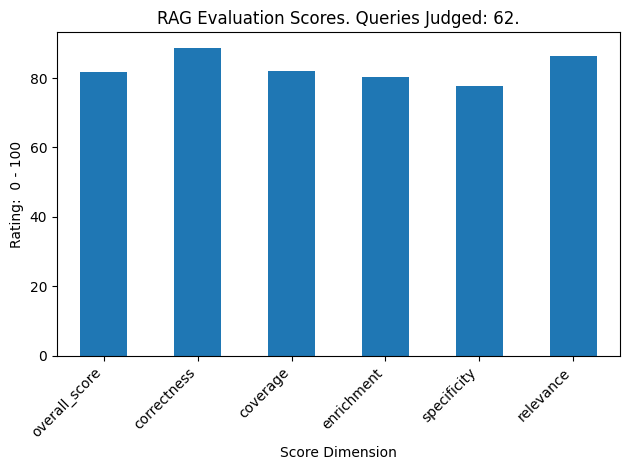

In [5]:
score_cols = ['overall_score','correctness','coverage','enrichment','specificity','relevance']
judge_averages = (judge_df[score_cols]).mean()
judge_averages.plot(kind='bar')
total_evaluations = len(evaluations)
plt.title(f'RAG Evaluation Scores. Queries Judged: {total_evaluations}.')
plt.xlabel('Score Dimension')
plt.ylabel('Rating:  0 - 100')
plt.xticks(rotation=45, ha='right') 
plt.tight_layout() 
plt.savefig('EvaluationAvgs.png')
plt.show()

In [6]:
overall_score = judge_averages['overall_score']
correctness = judge_averages['correctness']
coverage = judge_averages['coverage']
enrichment = judge_averages['enrichment']
specificity = judge_averages['specificity']
relevance = judge_averages['relevance']

score_report = f""" 
Score Averages.

overall_score: {overall_score}.

correctness: {correctness}. 

coverage: {coverage}.

enrichment: {enrichment}.

specificity: {specificity}.

relevance: {relevance}.
"""

print(score_report)

 
Score Averages.

overall_score: 81.6774193548387.

correctness: 88.70967741935483. 

coverage: 82.01612903225806.

enrichment: 80.16129032258064.

specificity: 77.8225806451613.

relevance: 86.20967741935483.

